In [66]:
from spice.models import IcosphereModel
from spice.models.mesh_transform import add_pulsation, evaluate_pulsations
from spice.plots import plot_3D_mesh_and_spectrum
from spice.spectrum import simulate_observed_flux, PhysicalLineEmulator
import astropy.units as u
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

from jax import config
# config.update('jax_platform_name', 'cpu')
config.update('jax_enable_x64', True)

ImportError: cannot import name 'PhysicalLineEmulator' from 'spice.spectrum' (/scratch/y89/mj8805/miniforge/envs/astro/lib/python3.12/site-packages/spice/spectrum/__init__.py)

In [24]:
from transformer_payne import TransformerPayne

tp = TransformerPayne.download()

wvs = jnp.log10(jnp.linspace(5498.5, 5499.5, 2000))

In [25]:
m = IcosphereModel.construct(2000, 1., 1.,
                             tp.to_parameters(), tp.stellar_parameter_names,
                             max_pulsation_mode=20)
m = add_pulsation(m, 20, 0, 5*u.min.to(u.d), jnp.array([[2*1e-6, 0.]]))

In [26]:
TIMESTAMPS = jnp.linspace(0., 2., 20)
mps = [evaluate_pulsations(m, t) for t in tqdm(TIMESTAMPS)]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  8.38it/s]


In [27]:
spectra = [simulate_observed_flux(tp.intensity, mp, wvs) for mp in tqdm(mps)]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:27<00:00,  7.35s/it]


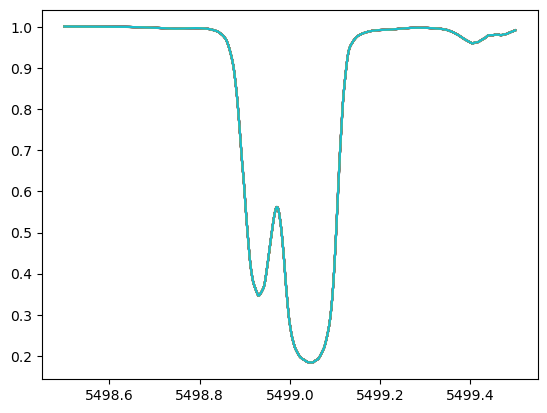

In [28]:
for s in spectra:
    plt.plot(10**wvs, s[:, 0]/s[:, 1])
plt.show()

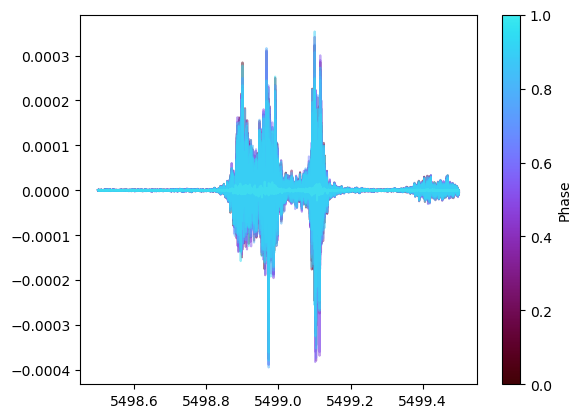

In [29]:
import cmasher as cmr
# Compute phases from timestamps (assuming period=1 for normalization)
phases = (TIMESTAMPS - TIMESTAMPS[0]) / (TIMESTAMPS[-1] - TIMESTAMPS[0])
norm = plt.Normalize(phases.min(), phases.max())
cmap = cmr.gem

fig, ax = plt.subplots()
for s, phase in zip(spectra, phases):
    ax.plot(10**wvs, (s[:, 0]/s[:, 1])-(spectra[0][:, 0]/spectra[0][:, 1]), color=cmap(norm(phase)), alpha=0.5)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array(phases)
cbar = fig.colorbar(sm, ax=ax, label='Phase')
plt.show()